In [655]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

**EDA**

In [656]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQw9pANi2VIh8-bR7RH2HSpKpKrxjs_SIyM5eNB39edar4Va6DPHmsghXsy6uOcXlRcWn2Q1qFzn5an/pub?gid=0&single=true&output=csv')
#df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRjkND-e30EeUVvNza7QEyNuKEn-FHGVld1C2hxzvdi6CD6GCZENaXsFWS8Q0j_F5QbNiGZ7QLkbXZP/pub?gid=207100874&single=true&output=csv',encoding='latin', usecols=[0, 1,2])
df.head()

,Date,Open,High,Low,Close,Volume
0,02/01/2014 16:56:00,"15,8","15,9","15,62","15,79",12689100
1,03/01/2014 16:56:00,"15,78","15,92","15,68","15,76",20059400
2,06/01/2014 16:56:00,"15,72","15,88","15,68","15,78",12794200
3,07/01/2014 16:56:00,"15,77","15,94","15,61","15,66",12681000
4,08/01/2014 16:56:00,"15,7","15,91","15,7","15,91",10816500


In [658]:
df['Date'] = df.Date.replace(' 16:56:00','',regex=True)
for i in df.drop(['Date'],axis=1).columns:
  df[i] = df[i].replace(',','.',regex=True)

#data cleaning

In [659]:
df.tail()

,Date,Open,High,Low,Close,Volume
1469,11/12/2019,36.5,36.67,35.56,35.6,37043600
1470,12/12/2019,35.95,36.09,35.35,35.59,23355500
1471,13/12/2019,35.8,36.37,35.35,36.31,27255500
1472,16/12/2019,36.44,36.64,35.48,35.48,21663700
1473,17/12/2019,35.75,36.28,35.54,36.02,19250800


In [660]:
df1= df.drop(['Date'],axis=1)
df.Date = pd.to_datetime(df['Date'], format ='%d/%m/%Y')
df[df1.columns] = df1.astype('float64')

In [661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 6 columns):
Date      1474 non-null datetime64[ns]
Open      1474 non-null float64
High      1474 non-null float64
Low       1474 non-null float64
Close     1474 non-null float64
Volume    1474 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 69.2 KB


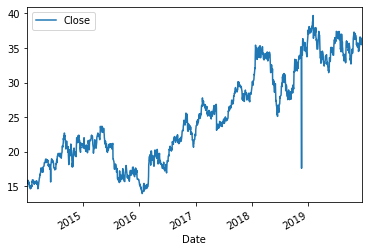

In [662]:
df.plot(x= 'Date',y='Close',kind='line')

In [663]:
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

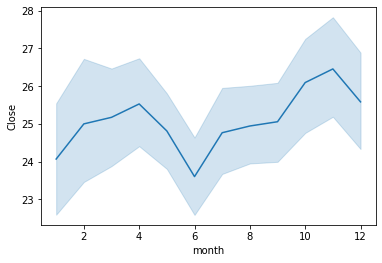

In [664]:
sns.lineplot(x='month',y='Close',data=df)

Text(0.5, 1.0, '2017')

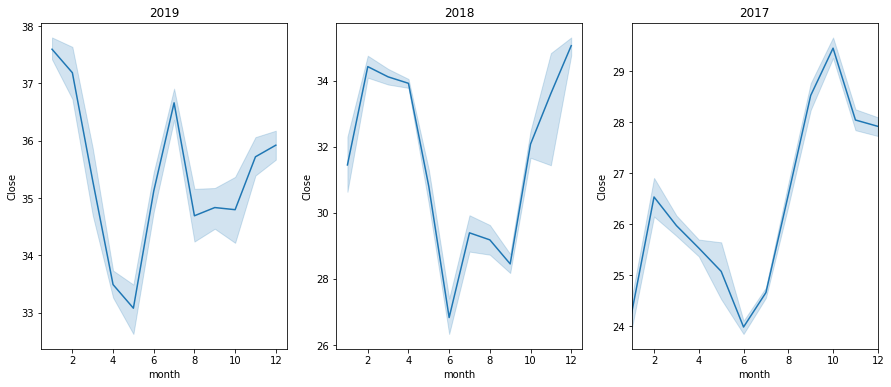

In [665]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
plt.xlim(left=1,right=12)
sns.lineplot(x='month',y='Close',data=df[df.year == 2018], ax=axs[1])
axs[1].set_title('2018')
sns.lineplot(x='month',y='Close',data=df[df.year == 2019],ax=axs[0])
axs[0].set_title('2019')
sns.lineplot(x='month',y='Close',data=df[df.year == 2017], ax=axs[2])
axs[2].set_title('2017')

# Checking the last 3 years
# ITUB4 pay dividends around May/June

**ARIMA Modeling for Stock Time Series**

In [666]:
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statistics

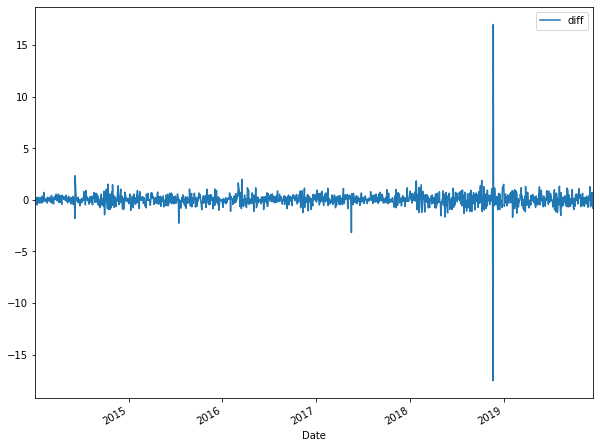

In [667]:
#Checking for stationarity
df['diff'] = df['Close'] - df['Close'].shift(1)
df.plot(kind='line',x='Date',y='diff', figsize = (10, 8))

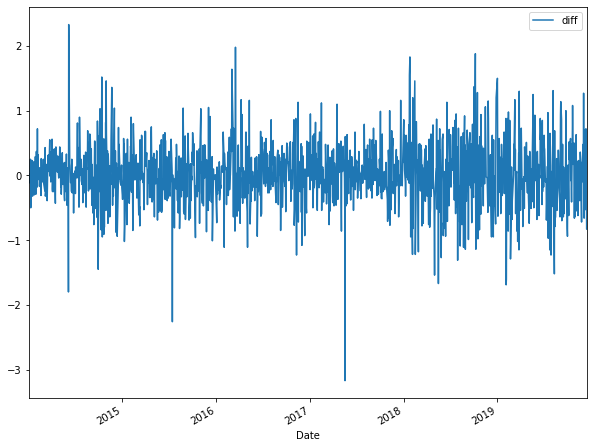

In [668]:
todrop = df[(df['diff'] > 10) | (df['diff']<-10)]
df.drop(todrop.index,inplace=True)
#droping "outlier"
df.plot(kind='line',x='Date',y='diff', figsize = (10, 8))

In [669]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(df['Close'].dropna())
# Close isn't stationary because test statistic > critical values

Results of Dickey-Fuller Test:
Test Statistic                   -1.048357
p-value                           0.735221
#Lags Used                        3.000000
Number of Observations Used    1468.000000
Critical Value (1%)              -3.434812
Critical Value (5%)              -2.863511
Critical Value (10%)             -2.567819
dtype: float64


In [670]:
adf_test(df['diff'].dropna())
# diff is stationary by the adf test so we can start our ARIMA model !

Results of Dickey-Fuller Test:
Test Statistic                  -24.459614
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1468.000000
Critical Value (1%)              -3.434812
Critical Value (5%)              -2.863511
Critical Value (10%)             -2.567819
dtype: float64


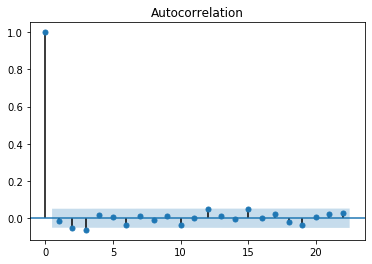

In [671]:
# Plotting ACF and PACF to check conditions
smt.graphics.plot_acf(df['diff'].dropna(), lags=22)
plt.show()

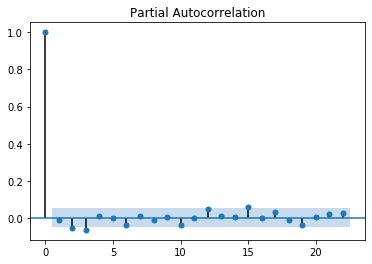

In [672]:
smt.graphics.plot_pacf(df['diff'].dropna(), lags=22)
plt.show()

In [673]:
df.set_index('Date',inplace=True)

# ARIMA Model

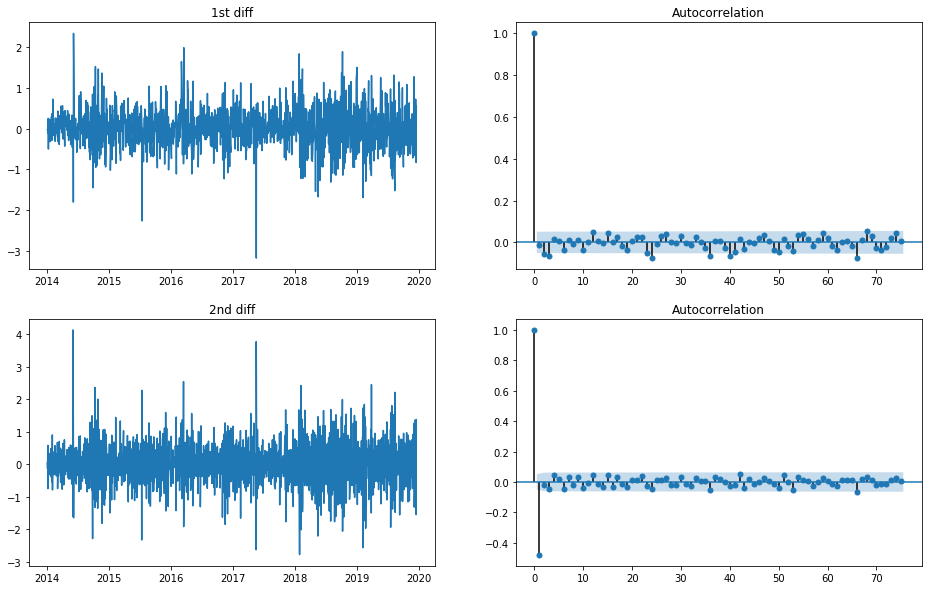

In [674]:
# choosing the order of differencing (d)
fig , ax = plt.subplots(2,2,figsize=(16,10))

ax[0,0].plot(df.Close.diff())
ax[0,0].set_title('1st diff')
plot_acf(df.Close.diff().dropna(), ax= ax[0,1],lags=75)

ax[1,0].plot(df.Close.diff().diff())
ax[1,0].set_title('2nd diff')
plot_acf(df.Close.diff().diff().dropna(), ax= ax[1,1],lags=75)

plt.show()
# 2nd diff goes negative too quickly, might be over differenced
# let's choose d = 1 as the series get "weakly" stationary to avoid over differencing

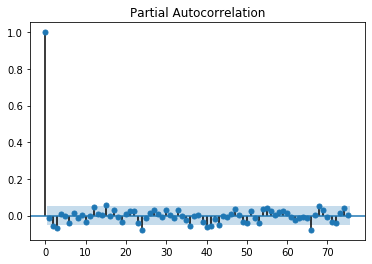

In [675]:
# choosing the order of the AR term (p)
plot_pacf(df.Close.diff().dropna(), lags=75)
plt.show()

# let's choose p=1 and test, it should be ok as the partial correlation is pretty decent

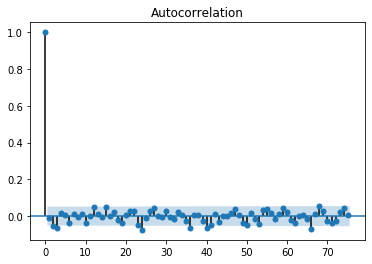

In [676]:
# The MA term (q)
plot_acf(df.Close.diff().dropna(),lags=75)
plt.show()

# We should use q to "fix" the lags over/under the significance line
# q=0 because there's nothing to fix apparently

In [677]:
# spliting the data
train = df[df.year<=2019][df.month<10]['Close']
test = df[df.year>=2019][df.month>=10]['Close']

In [678]:
model = ARIMA(train, order=(1,1,0))
modelfit = model.fit()
print(modelfit.summary())

# As we can see, the AR1 term has p>|z| = 0.667 and it should be less than 0.05, so we should not use it

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1119
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -871.590
Method:                       css-mle   S.D. of innovations              0.527
Date:                Wed, 18 Dec 2019   AIC                           1749.181
Time:                        13:06:07   BIC                           1764.241
Sample:                             1   HQIC                          1754.873
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0172      0.016      1.095      0.274      -0.014       0.048
ar.L1.D.Close    -0.0037      0.030     -0.125      0.900      -0.062       0.055
                                    Root

In [679]:
model = ARIMA(train, order=(1,0,0))
modelfit = model.fit()
print(modelfit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1120
Model:                     ARMA(1, 0)   Log Likelihood                -875.143
Method:                       css-mle   S.D. of innovations              0.527
Date:                Wed, 18 Dec 2019   AIC                           1756.287
Time:                        13:06:07   BIC                           1771.350
Sample:                             0   HQIC                          1761.980
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          25.0489      5.097      4.915      0.000      15.060      35.038
ar.L1.Close     0.9977      0.002    529.479      0.000       0.994       1.001
                                    Roots       

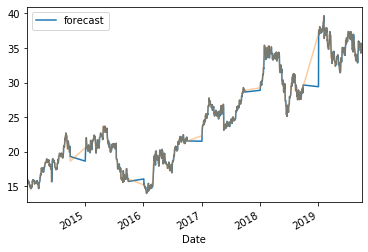

In [680]:
#Let's check our performance
modelfit.plot_predict(dynamic=False,plot_insample=False,)
plt.plot(train,alpha=0.4)
plt.show()

In [681]:
forecast = modelfit.forecast(54)[0]

In [682]:
# Evaluation by Mean Absolute Percentage Error (MAPE)

mape = np.mean(np.abs(forecast - test)/np.abs(test))
print(f'Mean Absolute Percentage Error - {round(mape*100,2)}%')

Mean Absolute Percentage Error - 4.27%
